# Cleaning and EDA

The following notebook is dedicated to cleaning and exploring the modeling data to determine which features will be used in subsequent models, as well as cleaning the validation data.

## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Reading In The Data

In [2]:
# Read in the modeling data
songs = pd.read_csv('data/songs.csv')

In [3]:
# Read in the validation data
val = pd.read_csv('data/val.csv')

The songs used in validation should not exist anywhere in the modeling data. This will ensure that the model works properly on unseen data. The cell below ensures that this is the case.

In [4]:
# Create a counter for the number of duplicates found
num_duplicates = 0

# Loop through all the URIs in the modeling data
for uri in songs['uri']:
    # Check if that URI exists in the modeling data
    if uri in val['uri'].values:
        # Increment the counter if duplicates are found
        num_duplicates += 1

# Display the number of validation songs that exist in the modeling data (should be 0)
num_duplicates

0

## Data For Modeling

In [5]:
# View a sample of the dataframe
songs.head()

,acousticness,analysis_url,danceability,duration_ms,energy,genre,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.002160,https://api.spotify.com/v1/audio-analysis/0yYh...,0.796,247493,0.864,dubstep,0yYhAqrI2t4zw9HbpUrMeY,0.628000,7,0.7780,-5.598,1,0.0495,139.972,4,https://api.spotify.com/v1/tracks/0yYhAqrI2t4z...,audio_features,spotify:track:0yYhAqrI2t4zw9HbpUrMeY,0.740
1,0.000148,https://api.spotify.com/v1/audio-analysis/2RUg...,0.891,250286,0.780,dubstep,2RUgUcKyAFLugNRy3G01wf,0.068100,11,0.2270,-6.847,1,0.2910,139.944,4,https://api.spotify.com/v1/tracks/2RUgUcKyAFLu...,audio_features,spotify:track:2RUgUcKyAFLugNRy3G01wf,0.622
2,0.002240,https://api.spotify.com/v1/audio-analysis/5yQm...,0.513,361875,0.819,dubstep,5yQmKyKEdjtxFDPIK9mFLn,0.153000,5,0.0580,-5.372,0,0.0454,140.055,4,https://api.spotify.com/v1/tracks/5yQmKyKEdjtx...,audio_features,spotify:track:5yQmKyKEdjtxFDPIK9mFLn,0.449
3,0.070400,https://api.spotify.com/v1/audio-analysis/1dQP...,0.373,237532,0.629,dubstep,1dQPIX6upFkwDI6ms2k52J,0.000001,9,0.0721,-4.752,0,0.0465,69.483,4,https://api.spotify.com/v1/tracks/1dQPIX6upFkw...,audio_features,spotify:track:1dQPIX6upFkwDI6ms2k52J,0.225
4,0.003930,https://api.spotify.com/v1/audio-analysis/3GLX...,0.581,315862,0.799,dubstep,3GLXFIHck82iqnWqhnm03n,0.766000,7,0.0791,-8.764,1,0.0318,139.994,4,https://api.spotify.com/v1/tracks/3GLXFIHck82i...,audio_features,spotify:track:3GLXFIHck82iqnWqhnm03n,0.339


### Cleaning

The following columns are only useful as internal identifiers for Spotify and will definitely not have any value to a model, so they should be removed.

In [6]:
# Drop meaningless columns
songs.drop([
    'analysis_url', 
    'id',
    'track_href', 
    'type', 
    'uri'
], axis=1, inplace=True)

In [7]:
# Check for null values in the data
songs.isna().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
genre               0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

Songs that are less than 100 seconds in duration are almost always intro or transitional tracks in a full-length concept album. These tracks may be labeled as dubstep, trance, etc., because they are part of an album belonging to that specific genre. However, they really don't represent the genres they are attributed to in the traditional sense. They almost always have little to no percussion and, upon listening to them, usually would be considered more of a soundscape track than true EDM song. For this reason, leaving them in the dataset would be counterproductive from a modeling standpoint, and thus they should be removed.

In [8]:
# Remove songs that are shorter than 100 seconds
songs = songs[songs['duration_ms'] > 100_000]

Songs that are more than 1000 seconds in duration are usually extended mixes or live sets. While they may be appropriately labeled by genre, these tracks don't represent a singular song, and becuase they are such strong outliers in duration, leaving them in the dataset will throw off the results of a model which is designed to analyze one song at a time. Therefore, these songs should be removed as well.

In [9]:
# Remove songs that are longer than 1000 seconds
songs = songs[songs['duration_ms'] < 1_000_000]

EDM music in general is relatively high-energy. Spotify gives every song an energy rating between 0 and 1. If that rating is lower than .3, this is another indicator that the song is likely not a true EDM song, but rather an intro or transitional track on a larger album. Thus, similarly to songs below 100 seconds in duration, they should also be removed.

In [10]:
# Remove songs with energy below .3
songs = songs[songs['energy'] > .3]

Spotify analyzes the audio every song in its library to determine the tempo in beats per minute. However, it is important to understand how the analyzer chooses what to designate as a beat, and how this affects the tempo. For example, say a song that is counted in quarter note beats has a tempo of 160. If that same song was counted in half note beats, which are twice as long as quarter note beats, then the analyzer would count half the number of beats, resulting in a tempo of 80. Neither one is technically wrong. It just depends on whether it is easier for the analyzer to recognize half notes or quarter notes.  

This means that tempos can be multiplied or divided by 2 without compromising the integrity of the data. The tempos in this dataset range from about 60 to 225 beats per minute, which is a huge and rather misleading range, since a tempo of 60 could also be thought of as 120, and a tempo of 220 could also be thought of as 110. From a modeling standpoint, this is problematic becuase the model will view 60 and 120 as different when they are really the same. To combat this, any tempos below 100 will be multiplied by 2 and ay tempos above 200 will be divided by 2. This will effectively deal with outliers in the data and keep the tempo in a uniform range between 100 and 200 beats per minute.

In [11]:
# A function to deal with outliers in tempo
# The range of tempos will be limited to range from 100 to 200
def tempo_adjuster(tempo):
    
    # Divide any tempo over 200 by 2
    if tempo > 200:
        tempo /= 2
        return tempo
    
    # Multiply any tempo under 100 by 2
    elif tempo < 100:
        tempo *= 2
        return tempo
    
    # Leave all other tempos alone
    else:
        return tempo

In [12]:
# Adjust the tempos for the modeling data
songs['tempo'] = songs['tempo'].map(tempo_adjuster)

In [13]:
# Check that all tempos are now between 100 and 200 beats per minute
print(f"{songs[songs['tempo'] < 100].shape[0]} songs below 100 beats per minute")
print(f"{songs[songs['tempo'] > 200].shape[0]} songs above 200 beats per minute")

0 songs below 100 beats per minute
0 songs above 200 beats per minute


In order to maintain completely balanced classes, data will be removed from the majority classes to balance with the minority class.

In [14]:
# A function to balance the classes in a dataset
def balance_classes(df, target):
    
    # Store the number of samples in the minority class
    limit = df[target].value_counts()[-1]
    # Create a new dataframe
    new_df = pd.DataFrame()
    
    # Loop through each of the possible classes
    for cat in df[target].value_counts().index:
        # Create a subset of all the samples belonging to that class
        cat_df = df[df[target] == cat]
        # Randomly select a number of samples equal to the number of samples in the minority class
        cat_df = cat_df.sample(limit, random_state=72)
        # Add this to the final dataframe
        new_df = pd.concat([new_df, cat_df])
    
    # Return the final dataframe
    return new_df

In [15]:
# Balance the classes for the modeling data
songs = balance_classes(songs, 'genre')

In [16]:
# Classes are now balanced
songs['genre'].value_counts()

drum-and-bass    995
house            995
trance           995
dubstep          995
Name: genre, dtype: int64

### Exploratory Data Analysis

In order to determine which features will be most consequential for modeling, each variable will be analyzed by comparing the distributions of each genre along that variable. The goal is to determine which variables exhibit distinct differences in these distributions, indicating which variables will be effective in predicting the genre of a song.

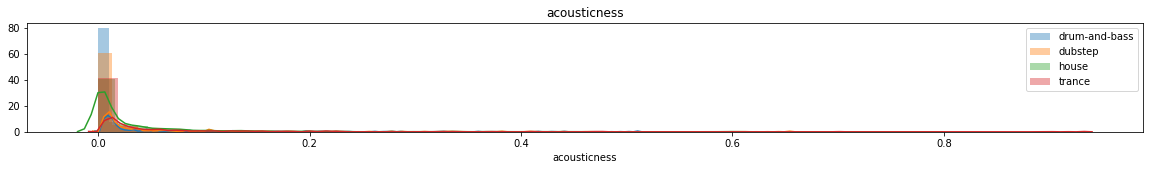

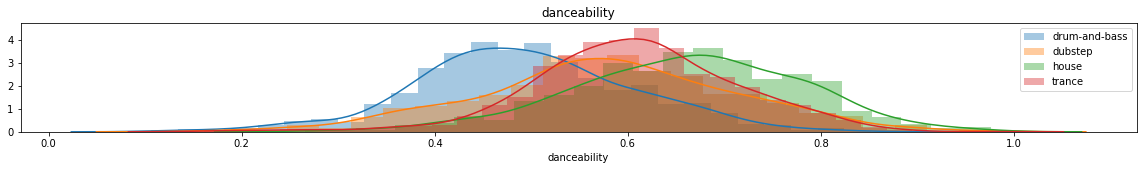

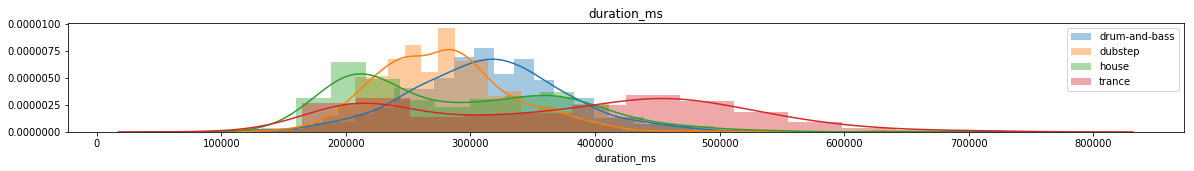

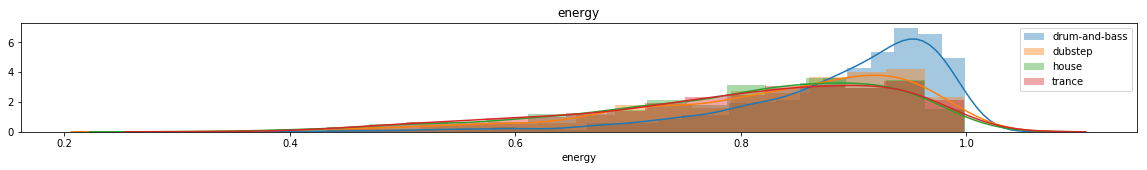

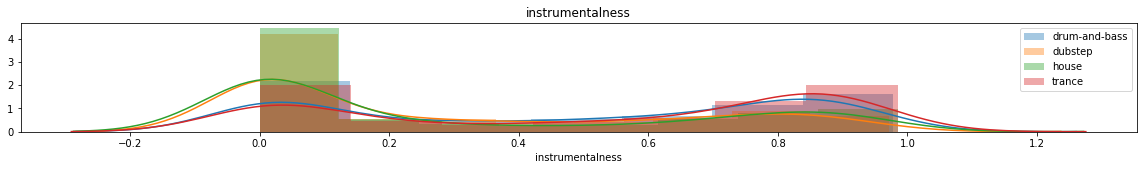

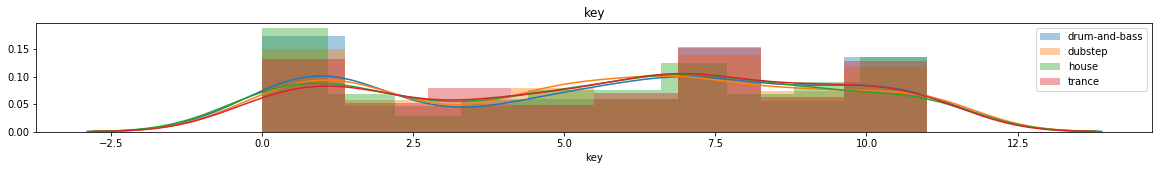

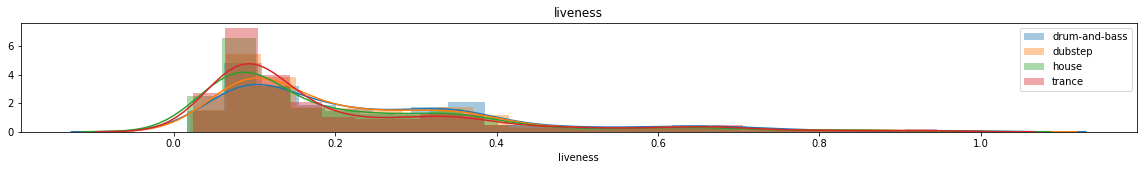

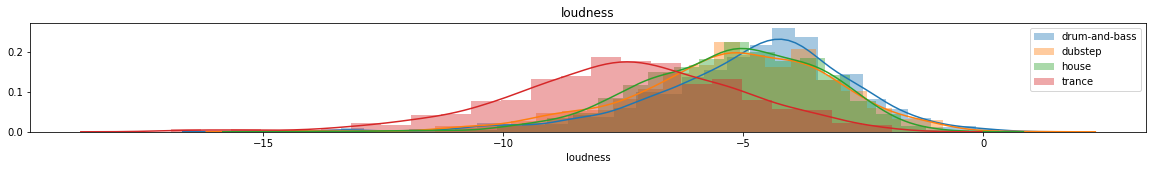

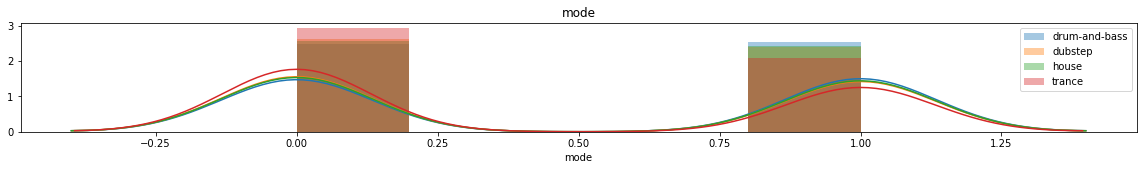

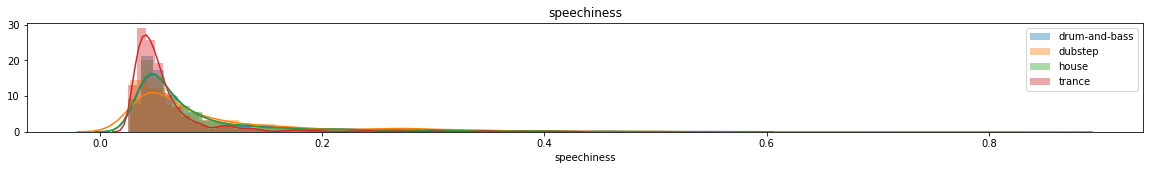

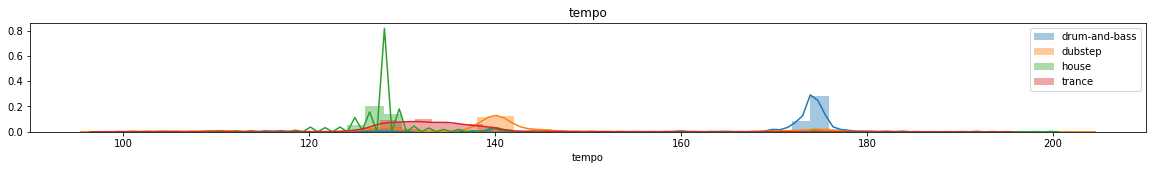

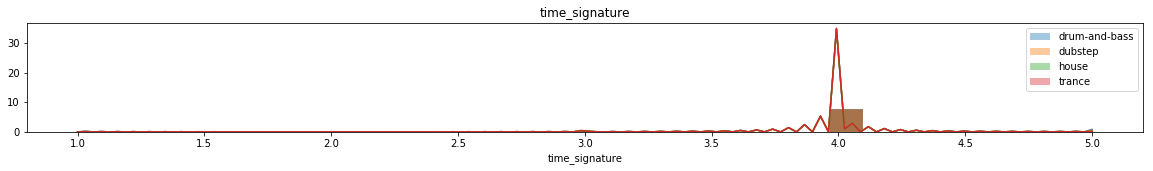

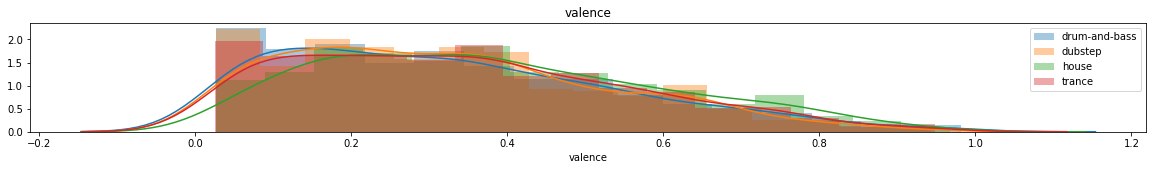

In [17]:
# Show the distibutions of each numeric variable, separated by genre

# Loop through each numeric column
for col in songs.select_dtypes(include='number').columns:
    # Create a list of labels for the legend
    labels = []
    # Create a figure to show distributions
    plt.figure(figsize=(20,2))
    # Group the data by genre and loop through each group
    for genre, group in songs.groupby('genre'):
        # Plot the distribution of the given column for the given genre
        sns.distplot(group[col])
        # Add the genre to the legend list
        labels.append(genre)
    # Plot the legend
    plt.legend(labels)
    # Title the plot by column
    plt.title(col)
    # Show the figure
    plt.show()

As can be seen above, the variable showing the clearest difference in distributions by genre is tempo, but danceability, duration, energy, and loudness have distinguishable differences as well. The rest of the variables have only negligible differences in distributions by genre and therefore will not be used for modeling.

In [18]:
# Drop less important columns
songs.drop([
    'acousticness', 
    'key', 
    'instrumentalness', 
    'liveness', 
    'mode', 
    'speechiness', 
    'time_signature',
    'valence'
], axis=1, inplace=True)

In [19]:
# Save the cleaned modeling data to a csv file
songs.to_csv('data/songs_clean.csv', index=False)

## Data For Validation

The same cleaning process will also be applied to the validation data.

In [20]:
# View a sample of the dataframe
val.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,genre
0,0.00659,https://api.spotify.com/v1/audio-analysis/2qOS...,0.741,170481,0.937,2qOS00vav7CVkOwfkkXktG,0.621000,11,0.3560,-3.531,0,0.1580,125.955,4,https://api.spotify.com/v1/tracks/2qOS00vav7CV...,audio_features,spotify:track:2qOS00vav7CVkOwfkkXktG,0.906,house
1,0.05470,https://api.spotify.com/v1/audio-analysis/6y1U...,0.744,188640,0.790,6y1UtRcHQU07aUs3oxZ8Yn,0.000802,8,0.3200,-4.617,0,0.0562,125.002,4,https://api.spotify.com/v1/tracks/6y1UtRcHQU07...,audio_features,spotify:track:6y1UtRcHQU07aUs3oxZ8Yn,0.847,house
2,0.00129,https://api.spotify.com/v1/audio-analysis/7hU3...,0.823,207293,0.815,7hU38LHqMSPFrvoqADFJp4,0.049400,11,0.5990,-3.947,1,0.1340,125.989,4,https://api.spotify.com/v1/tracks/7hU38LHqMSPF...,audio_features,spotify:track:7hU38LHqMSPFrvoqADFJp4,0.474,house
3,0.04360,https://api.spotify.com/v1/audio-analysis/27nf...,0.834,327805,0.896,27nfKLXSw4Mmg0JMDcke93,0.552000,0,0.3560,-5.303,1,0.1150,122.998,4,https://api.spotify.com/v1/tracks/27nfKLXSw4Mm...,audio_features,spotify:track:27nfKLXSw4Mmg0JMDcke93,0.735,house
4,0.00411,https://api.spotify.com/v1/audio-analysis/5Fzu...,0.566,155250,0.954,5FzuDFYmUFcvjraadJXv28,0.025700,6,0.0943,-4.678,1,0.0376,125.967,4,https://api.spotify.com/v1/tracks/5FzuDFYmUFcv...,audio_features,spotify:track:5FzuDFYmUFcvjraadJXv28,0.887,house


In [21]:
# Drop meaningless columns
val.drop([
    'analysis_url', 
    'id',
    'track_href', 
    'type', 
    'uri'
], axis=1, inplace=True)

In [22]:
# Check for null values in the data
val.isna().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
genre               0
dtype: int64

Since none of the songs have a duration below 100 seconds or above 1000 seconds, and none of the songs have energy below .3, these steps can be skipped.

In [23]:
# Adjust the tempos for the validation data
val['tempo'] = val['tempo'].map(tempo_adjuster)

In [24]:
# Check that all tempos are now between 100 and 200 beats per minute
print(f"{val[val['tempo'] < 100].shape[0]} songs below 100 beats per minute")
print(f"{val[val['tempo'] > 200].shape[0]} songs above 200 beats per minute")

0 songs below 100 beats per minute
0 songs above 200 beats per minute


In [25]:
# Drop less important columns
val.drop([
    'acousticness', 
    'key', 
    'instrumentalness', 
    'liveness', 
    'mode', 
    'speechiness', 
    'time_signature',
    'valence'
], axis=1, inplace=True)

In [26]:
# Check that classes are balanced
val['genre'].value_counts()

house            25
dubstep          25
trance           25
drum-and-bass    25
Name: genre, dtype: int64

In [27]:
# Save the cleaned validation data to a csv file
val.to_csv('data/val_clean.csv', index=False)